In [3]:
# Cell 1: Imports + Load CSVs

# 1) Import libraries we need
import pandas as pd          # for tables/dataframes
import numpy as np           # for numeric operations
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns        # for nicer plots (optional)

# Show more columns when we print dataframes
pd.set_option("display.max_columns", 200)

# 2) Define the path to your data folder
data_path = "../data/raw/"

# 3) Load the four CSV files into dataframes
benef_df   = pd.read_csv(data_path + "Train_Beneficiarydata.csv")
ip_df      = pd.read_csv(data_path + "Train_Inpatientdata.csv")
op_df      = pd.read_csv(data_path + "Train_Outpatientdata.csv")
labels_df  = pd.read_csv(data_path + "Train_Labels.csv")

# 4) Quick basic info: shapes
print("Beneficiary:", benef_df.shape)
print("Inpatient:", ip_df.shape)
print("Outpatient:", op_df.shape)
print("Labels:", labels_df.shape)


Beneficiary: (138556, 25)
Inpatient: (40474, 30)
Outpatient: (517737, 27)
Labels: (5410, 2)


In [4]:
# Cell 2: Peek into the data

dfs = {
    "benef_df": benef_df,
    "ip_df": ip_df,
    "op_df": op_df,
    "labels_df": labels_df
}

for name, df in dfs.items():
    print(f"\n=== {name} ===")
    print("Shape:", df.shape)
    print("First 3 rows:")
    print(df.head(3))        # look at first 3 rows
    print("\nMissing value % (top 10):")
    print(df.isna().mean().sort_values(ascending=False).head(10))



=== benef_df ===
Shape: (138556, 25)
First 3 rows:
      BeneID         DOB  DOD  Gender  Race RenalDiseaseIndicator  State  \
0  BENE11001  1943-01-01  NaN       1     1                     0     39   
1  BENE11002  1936-09-01  NaN       2     1                     0     39   
2  BENE11003  1936-08-01  NaN       1     1                     0     52   

   County  NoOfMonths_PartACov  NoOfMonths_PartBCov  ChronicCond_Alzheimer  \
0     230                   12                   12                      1   
1     280                   12                   12                      2   
2     590                   12                   12                      1   

   ChronicCond_Heartfailure  ChronicCond_KidneyDisease  ChronicCond_Cancer  \
0                         2                          1                   2   
1                         2                          2                   2   
2                         2                          2                   2   

   ChronicCond_Ob

In [5]:
# Cell 3: Feature engineering for ip_df

# 1) Convert date columns to datetime
ip_df["AdmissionDt"]  = pd.to_datetime(ip_df["AdmissionDt"])
ip_df["DischargeDt"]  = pd.to_datetime(ip_df["DischargeDt"])
ip_df["ClaimStartDt"] = pd.to_datetime(ip_df["ClaimStartDt"])
ip_df["ClaimEndDt"]   = pd.to_datetime(ip_df["ClaimEndDt"])

# 2) Length of admission (days in hospital)
ip_df["admit_days"] = (ip_df["DischargeDt"] - ip_df["AdmissionDt"]).dt.days + 1

# 3) Claim duration (difference between claim start and end)
ip_df["claim_days"] = (ip_df["ClaimEndDt"] - ip_df["ClaimStartDt"]).dt.days + 1

# 4) Count how many diagnosis codes a claim has (non-null entries)
diag_cols_ip = [c for c in ip_df.columns if c.startswith("ClmDiagnosisCode_")]
ip_df["n_diag_codes"] = ip_df[diag_cols_ip].notna().sum(axis=1)

# 5) Flag: does this claim have an OperatingPhysician filled?
ip_df["has_operating_physician"] = ip_df["OperatingPhysician"].notna().astype(int)

# Check result
ip_df[["Provider", "ClaimID", "admit_days", "claim_days", "n_diag_codes", "has_operating_physician"]].head()


,Provider,ClaimID,admit_days,claim_days,n_diag_codes,has_operating_physician
0,PRV55912,CLM46614,7,7,9,0
1,PRV55907,CLM66048,3,3,3,1
2,PRV56046,CLM68358,4,4,6,0
3,PRV52405,CLM38412,9,9,9,1
4,PRV56614,CLM63689,18,18,9,1


In [6]:
# Cell 4: Feature engineering for op_df

# 1) Convert claim dates to datetime
op_df["ClaimStartDt"] = pd.to_datetime(op_df["ClaimStartDt"])
op_df["ClaimEndDt"]   = pd.to_datetime(op_df["ClaimEndDt"])

# 2) Claim duration for outpatient
op_df["claim_days"] = (op_df["ClaimEndDt"] - op_df["ClaimStartDt"]).dt.days + 1

# 3) Count diagnosis codes for outpatient claims
diag_cols_op = [c for c in op_df.columns if c.startswith("ClmDiagnosisCode_")]
op_df["n_diag_codes"] = op_df[diag_cols_op].notna().sum(axis=1)

# 4) Operating physician flag for outpatient claims
op_df["has_operating_physician"] = op_df["OperatingPhysician"].notna().astype(int)

# Check result
op_df[["Provider", "ClaimID", "claim_days", "n_diag_codes", "has_operating_physician"]].head()


,Provider,ClaimID,claim_days,n_diag_codes,has_operating_physician
0,PRV56011,CLM624349,1,3,0
1,PRV57610,CLM189947,1,1,0
2,PRV57595,CLM438021,1,1,0
3,PRV56011,CLM121801,1,1,0
4,PRV56011,CLM150998,1,6,0


In [7]:
# Cell 5: Aggregate inpatient (ip_df) by Provider

ip_provider = ip_df.groupby("Provider").agg(
    ip_claim_count = ("ClaimID", "nunique"),             # how many distinct inpatient claims
    ip_bene_count  = ("BeneID", "nunique"),              # how many distinct patients
    ip_reimb_sum   = ("InscClaimAmtReimbursed", "sum"),  # total money reimbursed
    ip_reimb_mean  = ("InscClaimAmtReimbursed", "mean"), # average reimbursed per claim
    ip_admit_days_sum = ("admit_days", "sum"),           # total hospital days
    ip_claim_days_sum = ("claim_days", "sum"),           # total claim days
    ip_diag_mean      = ("n_diag_codes", "mean"),        # average number of diagnosis codes
    ip_has_operating_rate = ("has_operating_physician", "mean")  # % claims with operating physician
).reset_index()

ip_provider.head()


,Provider,ip_claim_count,ip_bene_count,ip_reimb_sum,ip_reimb_mean,ip_admit_days_sum,ip_claim_days_sum,ip_diag_mean,ip_has_operating_rate
0,PRV51001,5,5,97000,19400.000000,30,30,7.200000,0.400000
1,PRV51003,62,53,573000,9241.935484,382,382,8.112903,0.645161
2,PRV51007,3,3,19000,6333.333333,19,19,7.333333,0.333333
3,PRV51008,2,2,25000,12500.000000,10,10,7.500000,1.000000
4,PRV51011,1,1,5000,5000.000000,6,6,8.000000,0.000000


In [8]:
# Cell 6: Aggregate outpatient (op_df) by Provider

op_provider = op_df.groupby("Provider").agg(
    op_claim_count = ("ClaimID", "nunique"),
    op_bene_count  = ("BeneID", "nunique"),
    op_reimb_sum   = ("InscClaimAmtReimbursed", "sum"),
    op_reimb_mean  = ("InscClaimAmtReimbursed", "mean"),
    op_claim_days_sum = ("claim_days", "sum"),
    op_diag_mean      = ("n_diag_codes", "mean"),
    op_has_operating_rate = ("has_operating_physician", "mean")
).reset_index()

op_provider.head()


,Provider,op_claim_count,op_bene_count,op_reimb_sum,op_reimb_mean,op_claim_days_sum,op_diag_mean,op_has_operating_rate
0,PRV51001,20,19,7640,382.000000,31,2.200000,0.150000
1,PRV51003,70,66,32670,466.714286,235,2.714286,0.071429
2,PRV51004,149,138,52170,350.134228,362,2.583893,0.181208
3,PRV51005,1165,495,280910,241.124464,2433,2.588841,0.190558
4,PRV51007,69,56,14710,213.188406,122,2.797101,0.159420


In [9]:
# Cell 7: Build base provider_df

# Start from labels: 1 row per Provider with the fraud label
provider_df = labels_df.copy()   # columns: Provider, PotentialFraud

# Add inpatient aggregated features
provider_df = provider_df.merge(ip_provider, on="Provider", how="left")

# Add outpatient aggregated features
provider_df = provider_df.merge(op_provider, on="Provider", how="left")

provider_df.head()


,Provider,PotentialFraud,ip_claim_count,ip_bene_count,ip_reimb_sum,ip_reimb_mean,ip_admit_days_sum,ip_claim_days_sum,ip_diag_mean,ip_has_operating_rate,op_claim_count,op_bene_count,op_reimb_sum,op_reimb_mean,op_claim_days_sum,op_diag_mean,op_has_operating_rate
0,PRV51001,No,5.0,5.0,97000.0,19400.000000,30.0,30.0,7.200000,0.400000,20.0,19.0,7640.0,382.000000,31.0,2.200000,0.150000
1,PRV51003,Yes,62.0,53.0,573000.0,9241.935484,382.0,382.0,8.112903,0.645161,70.0,66.0,32670.0,466.714286,235.0,2.714286,0.071429
2,PRV51004,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.0,138.0,52170.0,350.134228,362.0,2.583893,0.181208
3,PRV51005,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1165.0,495.0,280910.0,241.124464,2433.0,2.588841,0.190558
4,PRV51007,No,3.0,3.0,19000.0,6333.333333,19.0,19.0,7.333333,0.333333,69.0,56.0,14710.0,213.188406,122.0,2.797101,0.159420


In [10]:
# Cell 8: Prepare beneficiary (benef_df) features

# 1) Convert DOB and DOD to datetime
benef_df["DOB"] = pd.to_datetime(benef_df["DOB"])

# DOD might be missing (if the patient didn't die)
benef_df["DOD"] = pd.to_datetime(benef_df["DOD"], errors="coerce")

# 2) Flag: is this patient dead?
benef_df["is_dead"] = benef_df["DOD"].notna().astype(int)

# 3) Approximate age at a reference date (end of data period)
reference_date = pd.Timestamp("2009-12-31")  # adjust if needed
benef_df["age"] = (reference_date - benef_df["DOB"]).dt.days / 365.25

# Check some columns
benef_df[["BeneID", "DOB", "DOD", "age", "is_dead"]].head()


,BeneID,DOB,DOD,age,is_dead
0,BENE11001,1943-01-01,NaT,66.997947,0
1,BENE11002,1936-09-01,NaT,73.330595,0
2,BENE11003,1936-08-01,NaT,73.415469,0
3,BENE11004,1922-07-01,NaT,87.501711,0
4,BENE11005,1935-09-01,NaT,74.332649,0


In [11]:
# Cell 9: Build Provider–Beneficiary pairs

# 1) Take only Provider and BeneID from IP and OP
ip_pairs = ip_df[["Provider", "BeneID"]]
op_pairs = op_df[["Provider", "BeneID"]]

# 2) Stack them together (some providers only have IP or only OP)
prov_bene = pd.concat([ip_pairs, op_pairs], axis=0)

# 3) Drop duplicate Provider–BeneID combinations
prov_bene = prov_bene.drop_duplicates()

# 4) Attach beneficiary info (age, is_dead, chronic conditions)
prov_bene = prov_bene.merge(benef_df, on="BeneID", how="left")

prov_bene.head()


,Provider,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,is_dead,age
0,PRV55912,BENE11001,1943-01-01,NaT,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,0,66.997947
1,PRV55907,BENE11001,1943-01-01,NaT,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,0,66.997947
2,PRV56046,BENE11001,1943-01-01,NaT,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,0,66.997947
3,PRV52405,BENE11011,1914-03-01,NaT,2,2,0,1,360,12,12,2,1,1,2,2,1,1,2,2,1,1,5000,1068,250,320,0,95.835729
4,PRV56614,BENE11014,1938-04-01,NaT,2,1,Y,45,780,12,12,2,1,1,2,1,1,2,1,2,2,2,21260,2136,120,100,0,71.750856


In [12]:
# Cell 10: Aggregate benef_df info at provider level

# Example chronic condition columns - adjust to your actual column names
chronic_cols = [
    "ChronicCond_Alzheimer",
    "ChronicCond_Heartfailure",
    "ChronicCond_Cancer"
]

# Group by Provider and aggregate stats
agg_dict = {
    "BeneID": "nunique",      # number of distinct patients per provider
    "age": ["mean", "std"],   # average and standard deviation of age
    "is_dead": "mean"         # % of patients who have DOD
}

# Add chronic conditions to aggregation dictionary as rate = mean of 0/1
for col in chronic_cols:
    agg_dict[col] = "mean"

benef_provider = prov_bene.groupby("Provider").agg(agg_dict)

# Flatten multi-level column names that come from agg with multiple statistics
benef_provider.columns = [
    "_".join(col).strip("_") for col in benef_provider.columns.values
]

# Rename to more readable names
benef_provider = benef_provider.rename(columns={
    "BeneID_nunique": "provider_bene_count",
    "age_mean": "provider_age_mean",
    "age_std": "provider_age_std",
    "is_dead_mean": "provider_dead_rate"
})

benef_provider = benef_provider.reset_index()

benef_provider.head()


,Provider,provider_bene_count,provider_age_mean,provider_age_std,provider_dead_rate,ChronicCond_Alzheimer_mean,ChronicCond_Heartfailure_mean,ChronicCond_Cancer_mean
0,PRV51001,24,78.669747,12.189902,0.000000,1.416667,1.250000,1.791667
1,PRV51003,117,69.473666,13.265545,0.008547,1.623932,1.401709,1.914530
2,PRV51004,138,72.946086,12.909559,0.007246,1.565217,1.405797,1.884058
3,PRV51005,495,70.517540,13.608518,0.006061,1.666667,1.468687,1.880808
4,PRV51007,58,68.486582,14.509705,0.017241,1.637931,1.482759,1.896552


In [13]:
# Cell 11: Add benef-based features to provider_df

provider_df = provider_df.merge(benef_provider, on="Provider", how="left")

provider_df.head()


,Provider,PotentialFraud,ip_claim_count,ip_bene_count,ip_reimb_sum,ip_reimb_mean,ip_admit_days_sum,ip_claim_days_sum,ip_diag_mean,ip_has_operating_rate,op_claim_count,op_bene_count,op_reimb_sum,op_reimb_mean,op_claim_days_sum,op_diag_mean,op_has_operating_rate,provider_bene_count,provider_age_mean,provider_age_std,provider_dead_rate,ChronicCond_Alzheimer_mean,ChronicCond_Heartfailure_mean,ChronicCond_Cancer_mean
0,PRV51001,No,5.0,5.0,97000.0,19400.000000,30.0,30.0,7.200000,0.400000,20.0,19.0,7640.0,382.000000,31.0,2.200000,0.150000,24,78.669747,12.189902,0.000000,1.416667,1.250000,1.791667
1,PRV51003,Yes,62.0,53.0,573000.0,9241.935484,382.0,382.0,8.112903,0.645161,70.0,66.0,32670.0,466.714286,235.0,2.714286,0.071429,117,69.473666,13.265545,0.008547,1.623932,1.401709,1.914530
2,PRV51004,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.0,138.0,52170.0,350.134228,362.0,2.583893,0.181208,138,72.946086,12.909559,0.007246,1.565217,1.405797,1.884058
3,PRV51005,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1165.0,495.0,280910.0,241.124464,2433.0,2.588841,0.190558,495,70.517540,13.608518,0.006061,1.666667,1.468687,1.880808
4,PRV51007,No,3.0,3.0,19000.0,6333.333333,19.0,19.0,7.333333,0.333333,69.0,56.0,14710.0,213.188406,122.0,2.797101,0.159420,58,68.486582,14.509705,0.017241,1.637931,1.482759,1.896552


In [14]:
# Cell 12: Create ratio / intensity features

# Small epsilon to avoid dividing by zero
eps = 1e-6

# 1) Total claims and total reimbursement per provider
provider_df["total_claim_count"] = provider_df["ip_claim_count"].fillna(0) + provider_df["op_claim_count"].fillna(0)
provider_df["total_reimb_sum"]   = provider_df["ip_reimb_sum"].fillna(0) + provider_df["op_reimb_sum"].fillna(0)

# 2) Ratios: per-claim and per-beneficiary
provider_df["reimb_per_claim"] = provider_df["total_reimb_sum"] / (provider_df["total_claim_count"] + eps)
provider_df["claims_per_bene"] = provider_df["total_claim_count"] / (provider_df["provider_bene_count"] + eps)
provider_df["reimb_per_bene"]  = provider_df["total_reimb_sum"] / (provider_df["provider_bene_count"] + eps)

# 3) Shares: how much is IP vs OP
provider_df["ip_claim_share"] = provider_df["ip_claim_count"].fillna(0) / (provider_df["total_claim_count"] + eps)
provider_df["op_claim_share"] = provider_df["op_claim_count"].fillna(0) / (provider_df["total_claim_count"] + eps)

# 4) Treatment intensity: days per claim
provider_df["total_claim_days_sum"] = provider_df["ip_claim_days_sum"].fillna(0) + provider_df["op_claim_days_sum"].fillna(0)
provider_df["days_per_claim"] = provider_df["total_claim_days_sum"] / (provider_df["total_claim_count"] + eps)

provider_df[[
    "Provider", "total_claim_count", "total_reimb_sum",
    "reimb_per_claim", "claims_per_bene", "ip_claim_share",
    "days_per_claim"
]].head()


,Provider,total_claim_count,total_reimb_sum,reimb_per_claim,claims_per_bene,ip_claim_share,days_per_claim
0,PRV51001,25.0,104640.0,4185.599833,1.041667,0.200000,2.440000
1,PRV51003,132.0,605670.0,4588.409056,1.128205,0.469697,4.674242
2,PRV51004,149.0,52170.0,350.134226,1.079710,0.000000,2.429530
3,PRV51005,1165.0,280910.0,241.124463,2.353535,0.000000,2.088412
4,PRV51007,72.0,33710.0,468.194438,1.241379,0.041667,1.958333


In [15]:
# Cell 13: Clean numeric NaNs + encode target

# 1) Find numeric columns
numeric_cols = provider_df.select_dtypes(include=[np.number]).columns

# 2) Fill missing numeric values with 0 (simple strategy)
provider_df[numeric_cols] = provider_df[numeric_cols].fillna(0)

# 3) Encode PotentialFraud as 0/1 binary label
#    Assuming PotentialFraud is "Yes"/"No"
provider_df["FraudLabel"] = (provider_df["PotentialFraud"] == "Yes").astype(int)

# 4) Optionally drop original string label (keep only numeric)
#    You can keep it if you want for readability
provider_df = provider_df.drop(columns=["PotentialFraud"])

provider_df.head()


,Provider,ip_claim_count,ip_bene_count,ip_reimb_sum,ip_reimb_mean,ip_admit_days_sum,ip_claim_days_sum,ip_diag_mean,ip_has_operating_rate,op_claim_count,op_bene_count,op_reimb_sum,op_reimb_mean,op_claim_days_sum,op_diag_mean,op_has_operating_rate,provider_bene_count,provider_age_mean,provider_age_std,provider_dead_rate,ChronicCond_Alzheimer_mean,ChronicCond_Heartfailure_mean,ChronicCond_Cancer_mean,total_claim_count,total_reimb_sum,reimb_per_claim,claims_per_bene,reimb_per_bene,ip_claim_share,op_claim_share,total_claim_days_sum,days_per_claim,FraudLabel
0,PRV51001,5.0,5.0,97000.0,19400.000000,30.0,30.0,7.200000,0.400000,20.0,19.0,7640.0,382.000000,31.0,2.200000,0.150000,24,78.669747,12.189902,0.000000,1.416667,1.250000,1.791667,25.0,104640.0,4185.599833,1.041667,4359.999818,0.200000,0.800000,61.0,2.440000,0
1,PRV51003,62.0,53.0,573000.0,9241.935484,382.0,382.0,8.112903,0.645161,70.0,66.0,32670.0,466.714286,235.0,2.714286,0.071429,117,69.473666,13.265545,0.008547,1.623932,1.401709,1.914530,132.0,605670.0,4588.409056,1.128205,5176.666622,0.469697,0.530303,617.0,4.674242,1
2,PRV51004,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,149.0,138.0,52170.0,350.134228,362.0,2.583893,0.181208,138,72.946086,12.909559,0.007246,1.565217,1.405797,1.884058,149.0,52170.0,350.134226,1.079710,378.043476,0.000000,1.000000,362.0,2.429530,0
3,PRV51005,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,1165.0,495.0,280910.0,241.124464,2433.0,2.588841,0.190558,495,70.517540,13.608518,0.006061,1.666667,1.468687,1.880808,1165.0,280910.0,241.124463,2.353535,567.494948,0.000000,1.000000,2433.0,2.088412,1
4,PRV51007,3.0,3.0,19000.0,6333.333333,19.0,19.0,7.333333,0.333333,69.0,56.0,14710.0,213.188406,122.0,2.797101,0.159420,58,68.486582,14.509705,0.017241,1.637931,1.482759,1.896552,72.0,33710.0,468.194438,1.241379,581.206887,0.041667,0.958333,141.0,1.958333,0


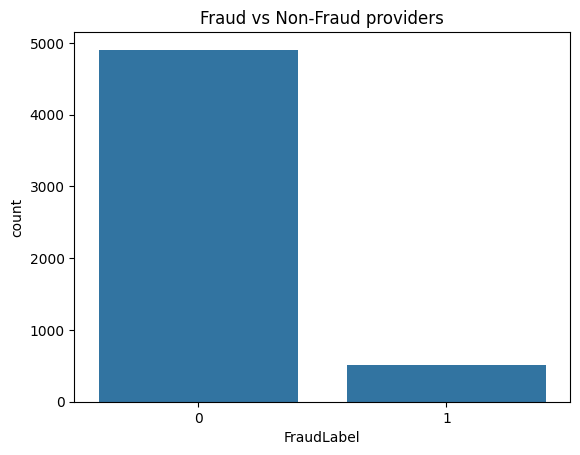

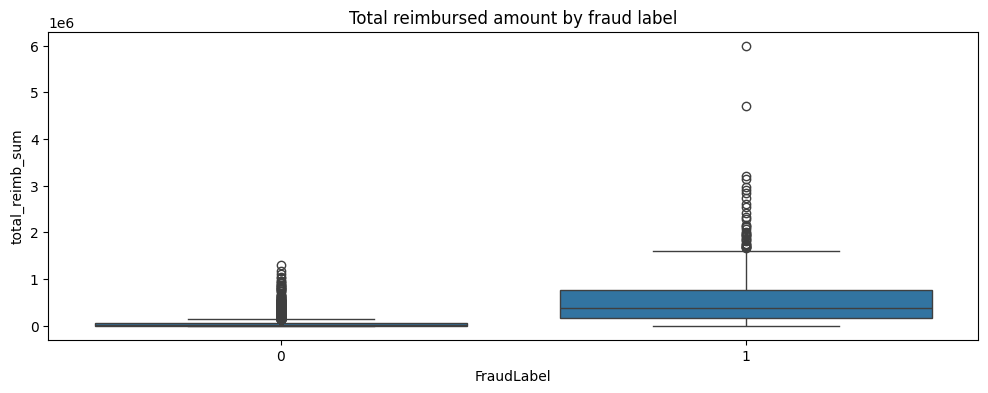

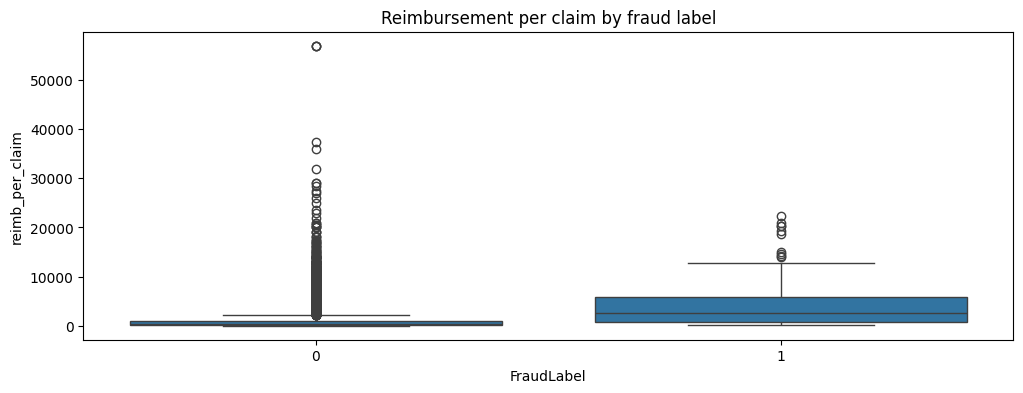

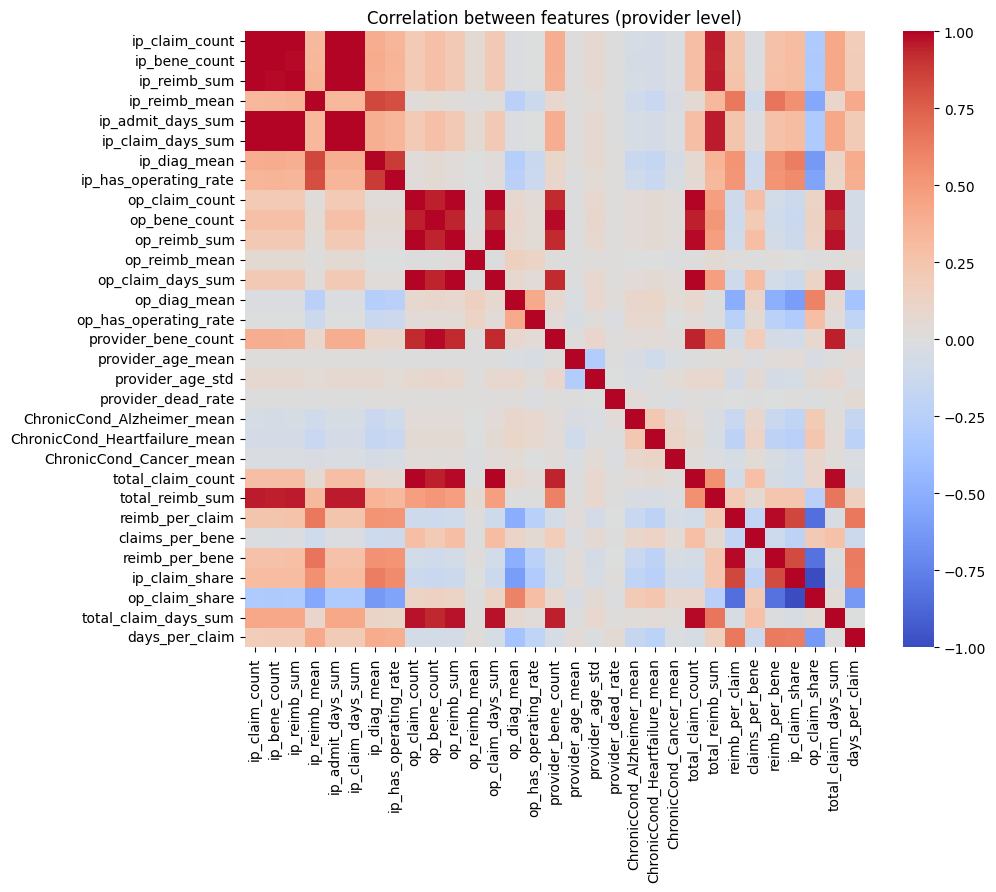

In [16]:
# Cell 14: Simple EDA plots on provider_df

# 1) Target distribution
sns.countplot(x="FraudLabel", data=provider_df)
plt.title("Fraud vs Non-Fraud providers")
plt.show()

# 2) Boxplot of key numeric features by fraud label
plt.figure(figsize=(12, 4))
sns.boxplot(x="FraudLabel", y="total_reimb_sum", data=provider_df)
plt.title("Total reimbursed amount by fraud label")
plt.show()

plt.figure(figsize=(12, 4))
sns.boxplot(x="FraudLabel", y="reimb_per_claim", data=provider_df)
plt.title("Reimbursement per claim by fraud label")
plt.show()

# 3) Correlation heatmap for numeric features
corr = provider_df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation between features (provider level)")
plt.show()


In [17]:
# Cell 15: Save provider_df for modeling

output_path = "../data/processed/"
provider_df.to_csv(output_path + "provider_df.csv", index=False)

print("Saved provider_df to", output_path + "provider_df.csv")


Saved provider_df to ../data/processed/provider_df.csv
